Saving Prices.csv to Prices (11).csv
        mean      sd    hdi_3%   hdi_97%  r_hat
α     21.156  10.128     2.945    41.035    1.0
β1     6.583   4.558    -2.059    15.033    1.0
β2     1.037  10.046   -17.342    19.746    1.0
σ   2295.141  73.806  2163.312  2437.543    1.0

β1 95% HDI = [-2.1502, 15.6971]
β2 95% HDI = [-18.1928, 20.3571]

Speed useful?         NO
ln(HardDrive) useful? NO

Posterior mean(μ) ~ -103.51
90% HDI(μ)         = [-245.64, 41.29]

Posterior mean(y_new) ~ -91.37
90% PI (HDI)          = [-4049.29, 3512.09]


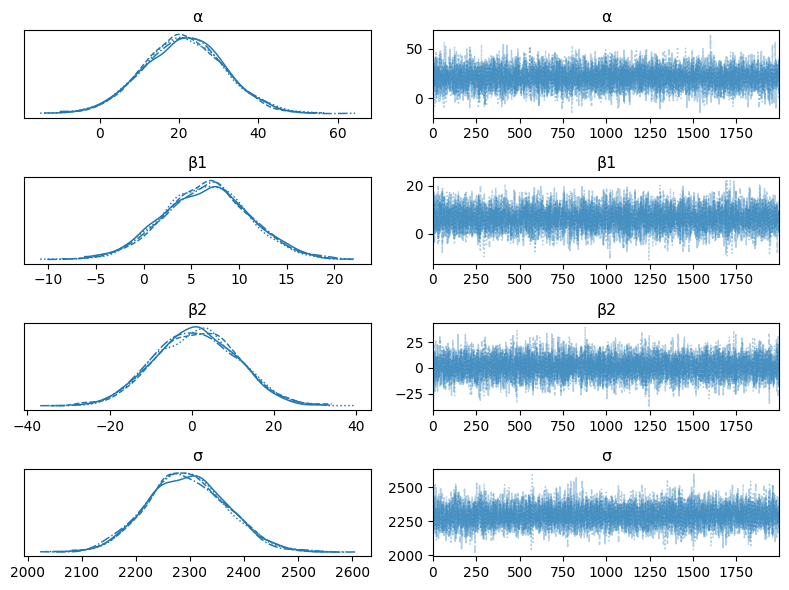

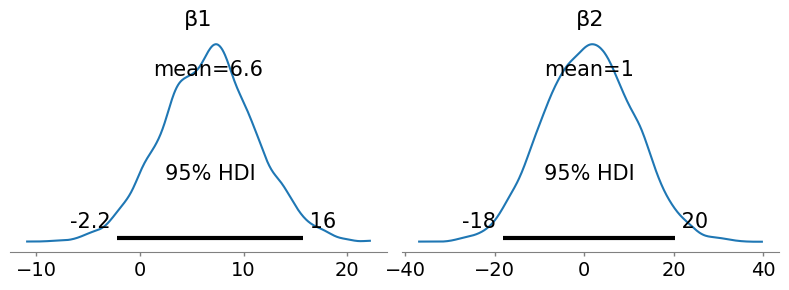

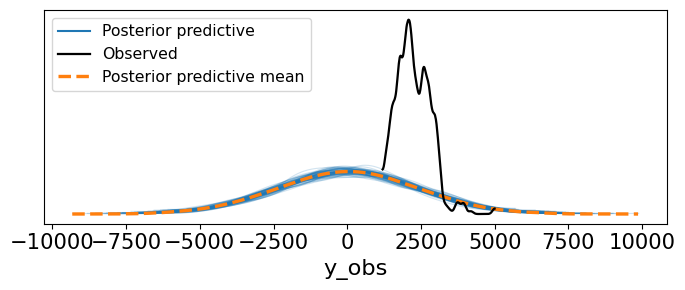


Premium effect:
     mean      sd  hdi_3%  hdi_97%  r_hat
β3  0.012  10.119  -19.91   18.143    1.0

β3 95% HDI = [-19.5610, 20.1170]


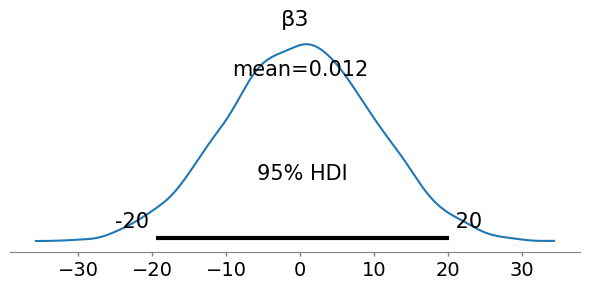

In [12]:
!pip -q install pymc arviz pandas numpy matplotlib

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from google.colab import files

az.rcParams["plot.max_subplots"] = 20

uploaded = files.upload()
csv_path = next(iter(uploaded.keys()))
df = pd.read_csv(csv_path)

y  = df["Price"].values.astype(float)
x1 = df["Speed"].values.astype(float)
x2 = np.log(df["HardDrive"].values.astype(float))

prem_raw = df["Premium"]
prem = prem_raw.str.lower().map({"yes": 1, "no": 0}).values.astype(float) if prem_raw.dtype == object else prem_raw.values.astype(float)

x1c = x1 - x1.mean()
x2c = x2 - x2.mean()
prem_c = prem - prem.mean()

def hdi_np(arr, prob):
    h = az.hdi(arr, hdi_prob=prob)
    return float(h[0]), float(h[1])

with pm.Model() as model:
    α  = pm.Normal("α", 0, 10)
    β1 = pm.Normal("β1", 0, 10)
    β2 = pm.Normal("β2", 0, 10)
    σ  = pm.HalfCauchy("σ", 5)

    μ = α + β1 * x1c + β2 * x2c
    pm.Normal("y_obs", mu=μ, sigma=σ, observed=y)

    idata = pm.sample(
        draws=2000, tune=2000, chains=4,
        target_accept=0.9, random_seed=42,
        return_inferencedata=True, progressbar=False
    )

summ = az.summary(idata, var_names=["α", "β1", "β2", "σ"])
print(summ[["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]].to_string())

post = idata.posterior.stack(sample=("chain", "draw"))
a  = post["α"].values
b1 = post["β1"].values
b2 = post["β2"].values
s  = post["σ"].values

b1_l, b1_h = hdi_np(b1, 0.95)
b2_l, b2_h = hdi_np(b2, 0.95)

print(f"\nβ1 95% HDI = [{b1_l:.4f}, {b1_h:.4f}]")
print(f"β2 95% HDI = [{b2_l:.4f}, {b2_h:.4f}]")

print("\nSpeed useful?        ", "NO" if (b1_l <= 0 <= b1_h) else "YES")
print("ln(HardDrive) useful?", "NO" if (b2_l <= 0 <= b2_h) else "YES")

speed_new = 33.0
hd_new = 540.0
x1_newc = speed_new - x1.mean()
x2_newc = np.log(hd_new) - x2.mean()

mu_new = a + b1 * x1_newc + b2 * x2_newc
mu_mean = float(mu_new.mean())
mu_l, mu_h = hdi_np(mu_new, 0.90)

print(f"\nPosterior mean(μ) ~ {mu_mean:.2f}")
print(f"90% HDI(μ)         = [{mu_l:.2f}, {mu_h:.2f}]")

rng = np.random.default_rng(123)
y_new = rng.normal(mu_new, s)
y_mean = float(y_new.mean())
y_l, y_h = hdi_np(y_new, 0.90)

print(f"\nPosterior mean(y_new) ~ {y_mean:.2f}")
print(f"90% PI (HDI)          = [{y_l:.2f}, {y_h:.2f}]")

az.plot_trace(idata, var_names=["α", "β1", "β2", "σ"], figsize=(8, 6))
plt.tight_layout()
plt.show()

az.plot_posterior(idata, var_names=["β1", "β2"], hdi_prob=0.95, figsize=(8, 3))
plt.tight_layout()
plt.show()

with model:
    ppc = pm.sample_posterior_predictive(
        idata,
        var_names=["y_obs"],
        random_seed=42,
        progressbar=False,
        return_inferencedata=True
    )

az.plot_ppc(ppc, num_pp_samples=80, figsize=(7, 3))
plt.tight_layout()
plt.show()

with pm.Model() as model_prem:
    α  = pm.Normal("α", 0, 10)
    β1 = pm.Normal("β1", 0, 10)
    β2 = pm.Normal("β2", 0, 10)
    β3 = pm.Normal("β3", 0, 10)
    σ  = pm.HalfCauchy("σ", 5)

    μ = α + β1 * x1c + β2 * x2c + β3 * prem_c
    pm.Normal("y_obs", mu=μ, sigma=σ, observed=y)

    idata_p = pm.sample(
        draws=2000, tune=2000, chains=4,
        target_accept=0.9, random_seed=42,
        return_inferencedata=True, progressbar=False
    )

summ_p = az.summary(idata_p, var_names=["β3"])
print("\nPremium effect:")
print(summ_p[["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]].to_string())

post_p = idata_p.posterior.stack(sample=("chain", "draw"))
b3 = post_p["β3"].values
b3_l, b3_h = hdi_np(b3, 0.95)

print(f"\nβ3 95% HDI = [{b3_l:.4f}, {b3_h:.4f}]")

az.plot_posterior(idata_p, var_names=["β3"], hdi_prob=0.95, figsize=(6, 3))
plt.tight_layout()
plt.show()
